In [1]:
import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

import optuna
from optuna import Trial

import pandas as pd
import numpy as np
import cupy as cp

import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import os
import pathlib

import warnings


%matplotlib inline
sns.set_style(style="darkgrid")
warnings.filterwarnings(action="ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

device = torch.device(device=("cuda" if torch.cuda.is_available() else "cpu"))

In [2]:
import yfinance as yf

# Fetch Tesla stock data
df = yf.download("TSLA", start="2020-01-01", end="2025-03-28")
df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500
...,...,...,...,...,...
2025-03-21,248.710007,249.520004,234.550003,234.990005,132728700
2025-03-24,278.390015,278.640015,256.329987,258.079987,169079900


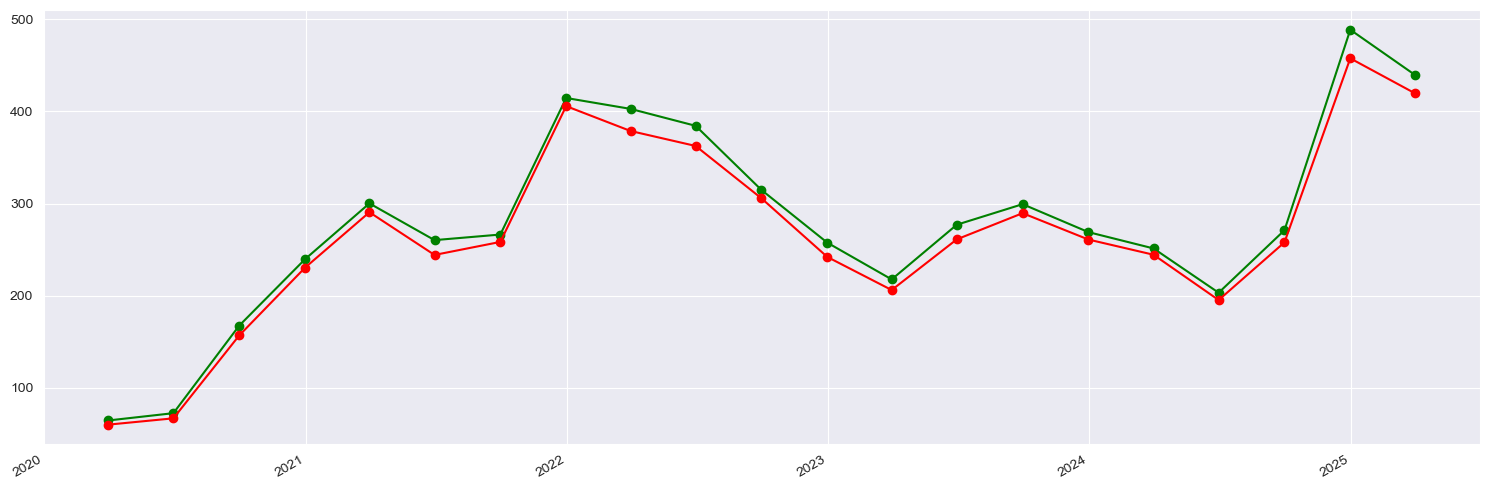

In [3]:
group_by_year_max = df.resample(rule="QE").max()
group_by_year_min = df.resample(rule="QE").min()

fig = plt.figure(figsize=(15,5))

plt.plot(group_by_year_max["High"], c="g", marker="o", label="maximum price in each quarter over the years")
plt.plot(group_by_year_max["Low"], c="r", marker="o", label="lowest price in each quarter over the years")

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

In [4]:
df.index = pd.to_datetime(df.index, format="%Y-%M-%d")

# Moving Average (Simple Smoothing)

<Axes: xlabel='Date'>

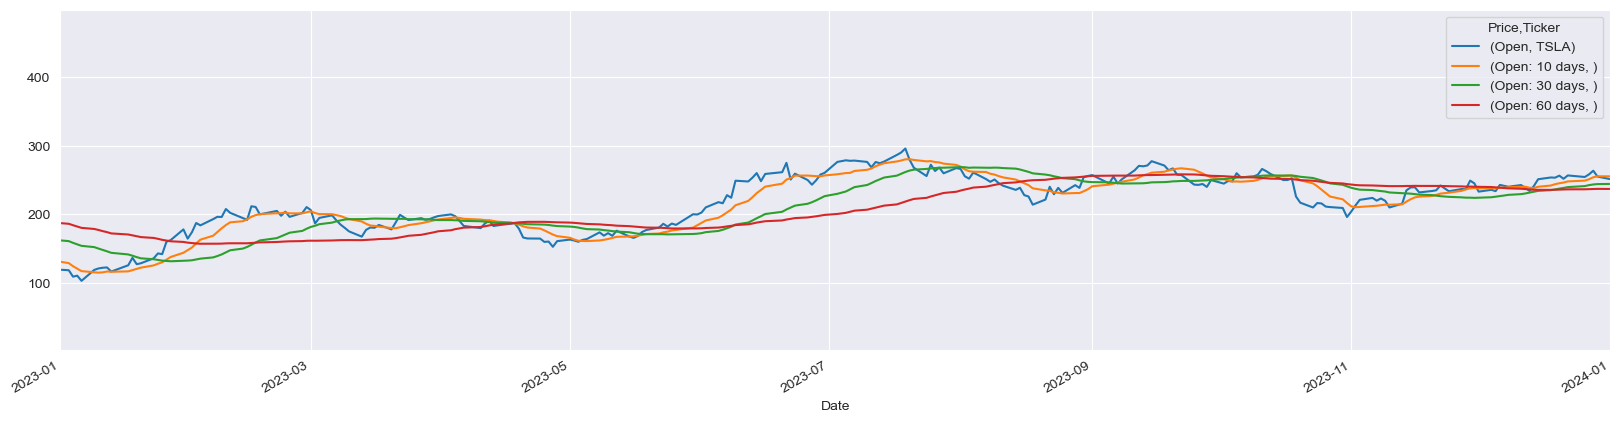

In [5]:
df["Open: 10 days"] = df[("Open", "TSLA")].rolling(window=10, min_periods=1).mean()
df["Open: 30 days"] = df[("Open", "TSLA")].rolling(window=30, min_periods=1).mean()
df["Open: 60 days"] = df[("Open", "TSLA")].rolling(window=60, min_periods=1).mean()
df.head(15)
df[["Open", "Open: 10 days", "Open: 30 days", "Open: 60 days"]].plot(xlim=["2023-01-01", "2024-01-01"], figsize=(20,5))


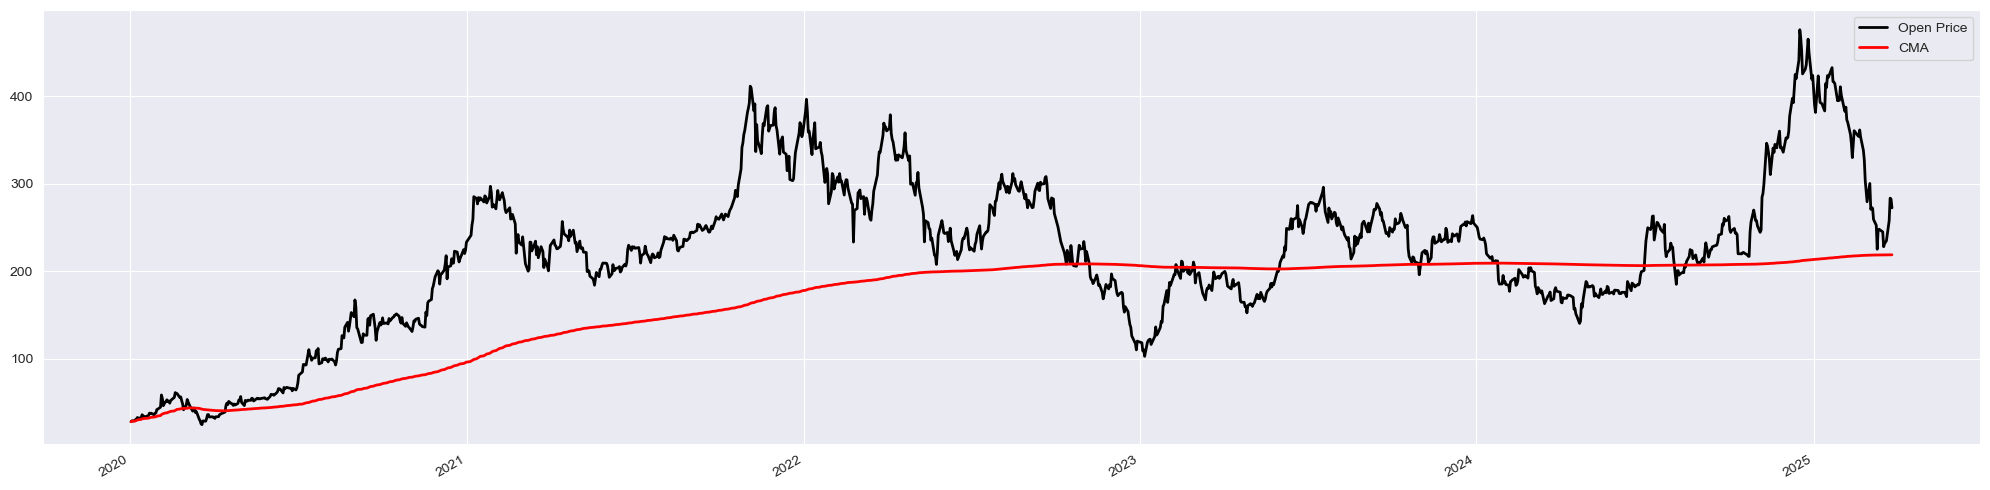

In [6]:


df.index = pd.to_datetime(df.index, format="%Y-%m-%d")

# Expanding: Cumulative Moving Average
cma_open = df["Open"].expanding().mean()

fig = plt.figure(figsize=(20, 5))

plt.plot(df["Open"], linewidth=2,c="black", label="Open Price")
plt.plot(cma_open, linewidth=2, c="r", label="CMA")

# ✅ Correct way to set xlim
# plt.xlim(pd.to_datetime(["2023-01-01", "2024-01-01"]))

fig.autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# Exponent Moving Average => open price

df["Open: 0.1_alpha"] = df["Open"].ewm(alpha=0.1, adjust=False).mean()
df["Open: 0.3_alpha"] = df["Open"].ewm(alpha=0.3, adjust=False).mean()
df["Open: 0.5_alpha"] = df["Open"].ewm(alpha=0.5, adjust=False).mean()
df["Open: 0.7_alpha"] = df["Open"].ewm(alpha=0.7, adjust=False).mean()
df["Open: 0.85_alpha"] = df["Open"].ewm(alpha=0.85, adjust=False).mean()


<Axes: xlabel='Date'>

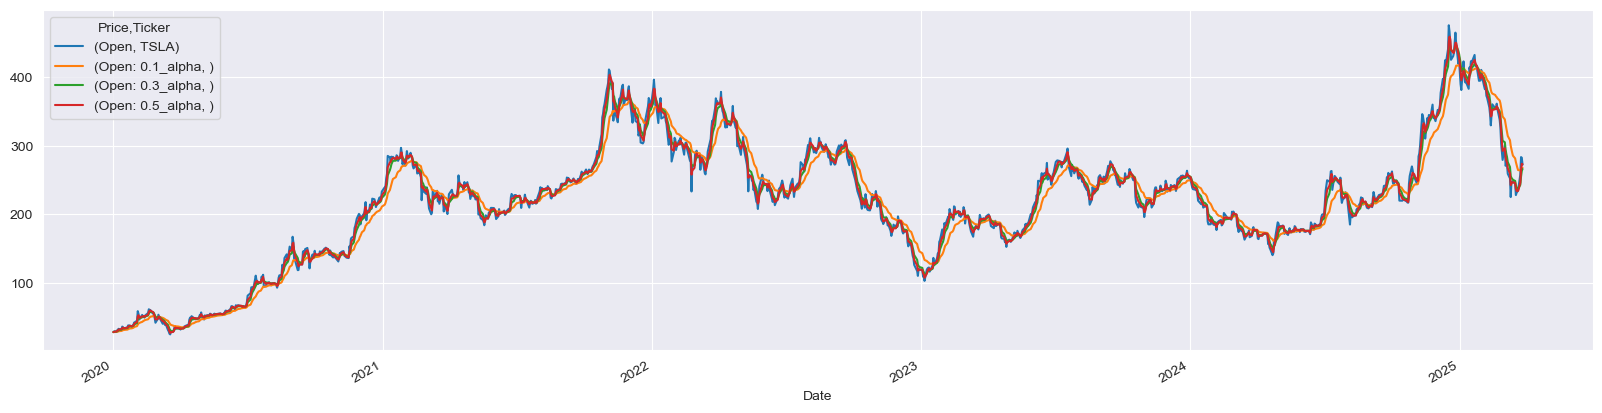

In [8]:
df[["Open", "Open: 0.1_alpha", "Open: 0.3_alpha", "Open: 0.5_alpha",]].plot(figsize=(20, 5))

<Axes: xlabel='Date'>

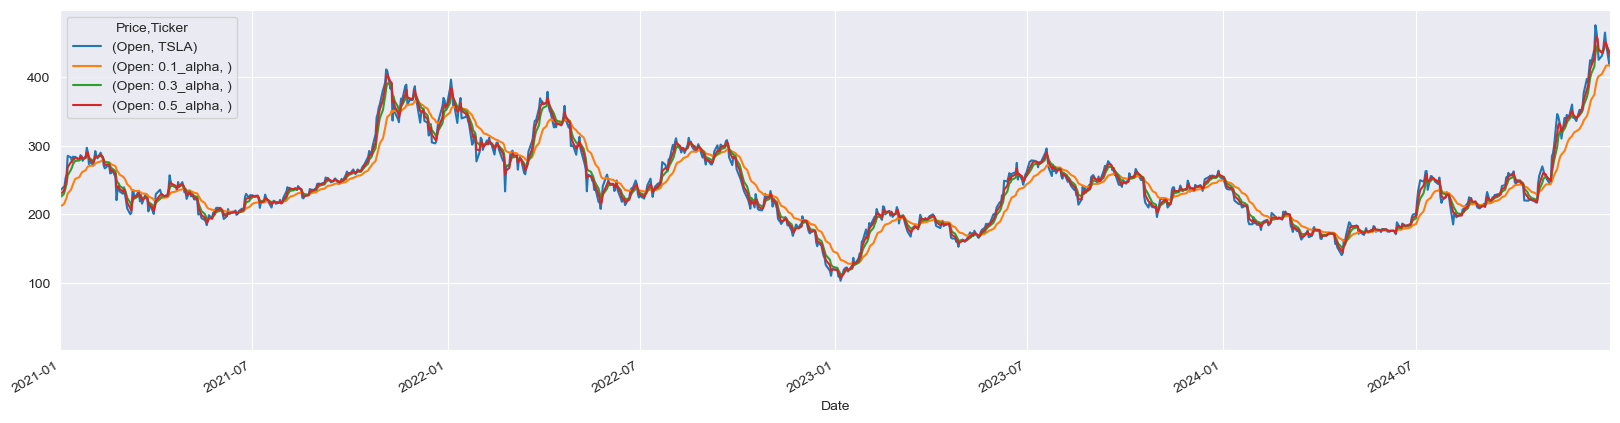

In [9]:
df[["Open", "Open: 0.1_alpha", "Open: 0.3_alpha", "Open: 0.5_alpha",]].plot(figsize=(20, 5), xlim=["2023-01-01", "2023-01-01"])

<Axes: xlabel='Date'>

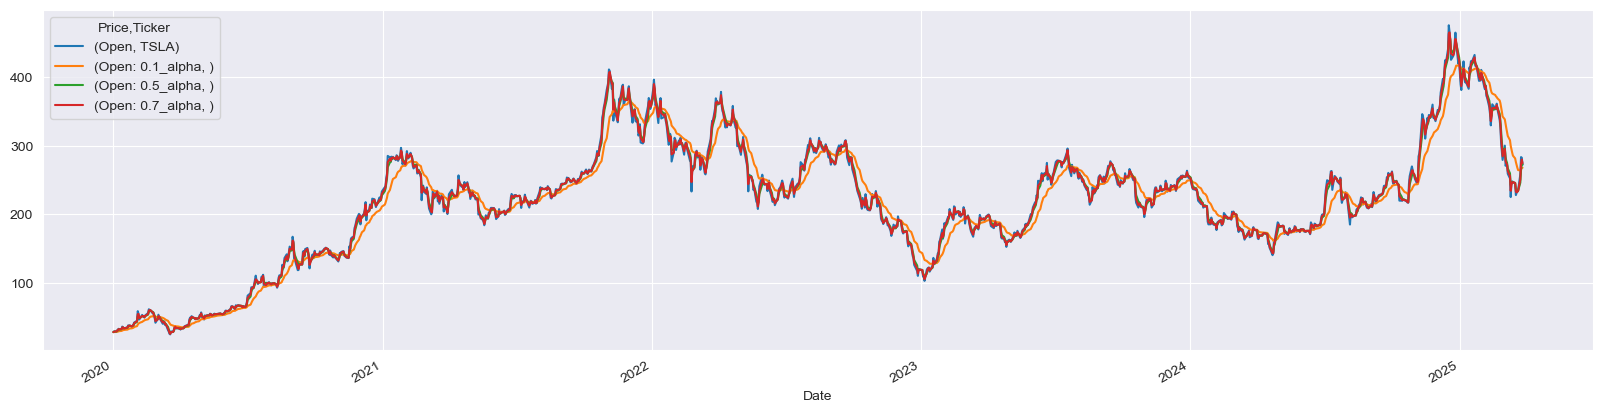

In [10]:
df[["Open", "Open: 0.1_alpha", "Open: 0.5_alpha", "Open: 0.7_alpha",]].plot(figsize=(20, 5))

<Axes: xlabel='Date'>

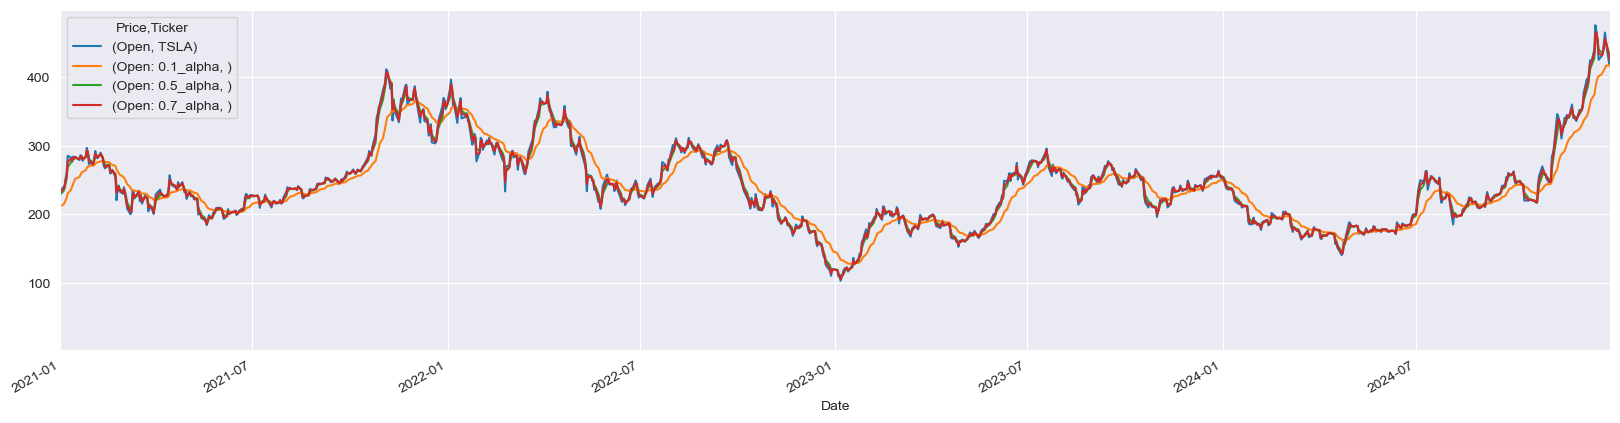

In [11]:
df[["Open", "Open: 0.1_alpha", "Open: 0.5_alpha", "Open: 0.7_alpha",]].plot(figsize=(20, 5), xlim=["2023-01-01", "2023-01-01"])

<Axes: xlabel='Date'>

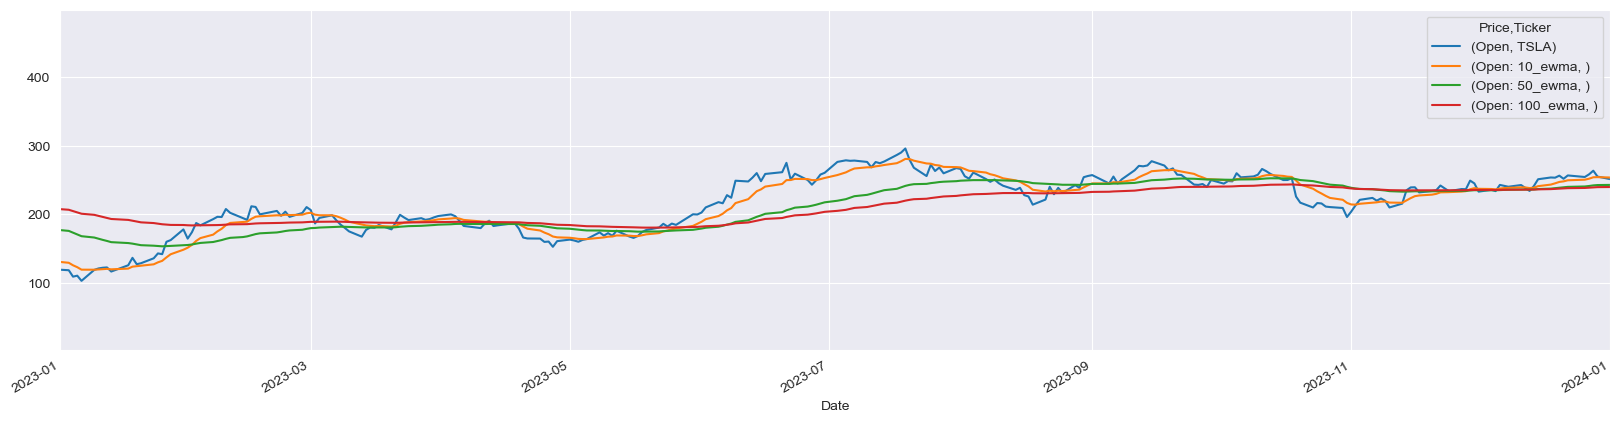

In [12]:
df["Open: 10_ewma"] = df["Open"].ewm(span=10).mean()
df["Open: 30_ewma"] = df["Open"].ewm(span=30).mean()
df["Open: 50_ewma"] = df["Open"].ewm(span=50).mean()
df["Open: 100_ewma"] = df["Open"].ewm(span=100).mean()
df[["Open", "Open: 10_ewma", "Open: 50_ewma", "Open: 100_ewma"]].plot(figsize=(20, 5), xlim=["2023-01-01", "2024-01-01"])